In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

In [19]:
#read in text data
posts = pd.read_csv("posts.csv")
comments = pd.read_csv("comments.csv")

In [20]:
#join comments to posts
merged = posts.merge(comments, on="post_id", how="right")
merged["author"] = merged["author"].astype(int)
merged["user_id"] = merged["user_id"].astype(int)

### Distribution of text lengths

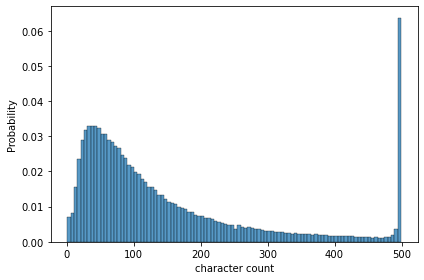

In [21]:
post_length = posts["content"].str.len()
sns.histplot(post_length[post_length<500], stat="probability", bins=100)
plt.xlabel("character count")
plt.tight_layout()
plt.savefig("post_cc")

In [22]:
#percent of posts excluded due to length>=500
sum(post_length[post_length>500].value_counts())/len(post_length)

0.0038695722402084373

In [23]:
#average post length
post_length.mean()

151.5507749678706

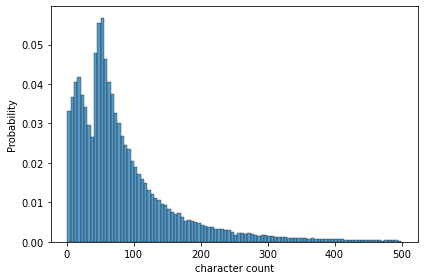

In [24]:
comment_length = comments["content"].str.len()
sns.histplot(comment_length[comment_length<500], stat="probability", bins=100)
plt.xlabel("character count")
plt.tight_layout()
plt.savefig("comment_cc")

In [25]:
#percent of comments excluded due to length>=500
sum(comment_length[comment_length>500].value_counts())/len(comment_length)

0.013919502644221066

In [26]:
#average comment length
comment_length.mean()

96.06949872420141

In [27]:
#Mann-Whitney U test for sentiment of comments and posts
print("BERT: " + str(mannwhitneyu(x=posts["bert_compound"], y=comments["bert_compound"], alternative="less")))
print("VADER: " + str(mannwhitneyu(x=posts["vader_score_compound"], y=comments["vader_score_compound"], alternative="less")))

BERT: MannwhitneyuResult(statistic=12601413552.5, pvalue=0.0)
VADER: MannwhitneyuResult(statistic=14874855772.0, pvalue=0.0)


### Distribution of sentiments

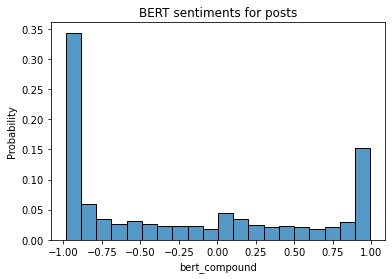

In [28]:
sns.histplot(posts["bert_compound"], stat="probability", bins=20)
plt.title("BERT sentiments for posts")
plt.savefig("posts_bert_sentiment")

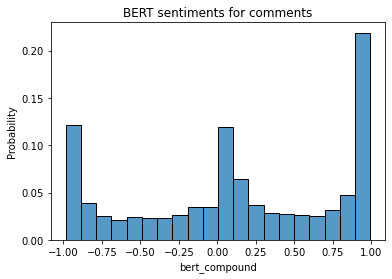

In [29]:
sns.histplot(comments["bert_compound"], stat="probability", bins=20)
plt.title("BERT sentiments for comments")
plt.savefig("comments_bert_sentiment")

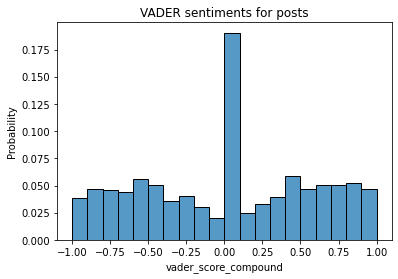

In [30]:
sns.histplot(posts["vader_score_compound"], stat="probability", bins=20)
plt.title("VADER sentiments for posts")
plt.savefig("posts_vader_sentiment")

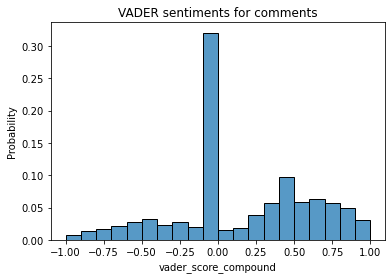

In [31]:
sns.histplot(comments["vader_score_compound"], stat="probability", bins=20)
plt.title("VADER sentiments for comments")
plt.savefig("comments_vader_sentiment")


### Calculate sentiment delta in comment chains

In [32]:
#filter for instances where OP commented on their post
deltas = merged[merged["author"]==merged["user_id"]]

deltas = deltas.sort_values(["post_id", "timestamp_y"])
post_ids = deltas.post_id.unique()
for pid in post_ids:
    #find every OP comment on given post
    slice = deltas[deltas["post_id"] == pid].sort_values("timestamp_y", ascending=True)
    #find every comment on given post
    comment_slice = merged[merged["post_id"] == pid]
    #remove OP comments
    comment_slice = merged[merged["user_id"] != merged["author"]]
    #OP delta between post and first comment for VADER
    deltas.loc[(slice.iloc[0].name, "OP_vader_delta")] = slice.iloc[0]["vader_score_compound_y"] - slice.iloc[0]["vader_score_compound_x"]
    #OP delta between post and first comment for BERT
    deltas.loc[(slice.iloc[0].name, "OP_bert_delta")] = slice.iloc[0]["bert_compound_y"] - slice.iloc[0]["bert_compound_x"]
    #average of VADER comment sentiments in block 1
    deltas.loc[slice.iloc[0].name, "comments_vader_avg"] = comment_slice[comment_slice["timestamp_y"] < slice.iloc[0]["timestamp_y"]]["vader_score_compound_y"].mean()
    #average of BERT comments sentiments in block 1
    deltas.loc[slice.iloc[0].name, "comments_bert_avg"] = comment_slice[comment_slice["timestamp_y"] < slice.iloc[0]["timestamp_y"]]["bert_compound_y"].mean()
    #for every other block after
    for i in range(1, len(slice)):
        deltas.loc[(slice.iloc[i].name, "OP_vader_delta")] = slice.iloc[i]["vader_score_compound_y"] - slice.iloc[i-1]["vader_score_compound_y"]
        deltas.loc[(slice.iloc[i].name, "OP_bert_delta")] = slice.iloc[i]["bert_compound_y"] - slice.iloc[i-1]["bert_compound_y"]
        deltas.loc[(slice.iloc[i].name, "comments_vader_avg")] = comment_slice[(comment_slice["timestamp_y"] < slice.iloc[i]["timestamp_y"])
                                                                              & (comment_slice["timestamp_y"] > slice.iloc[i-1]["timestamp_y"])]["vader_score_compound_y"].mean()
        deltas.loc[(slice.iloc[i].name, "comments_bert_avg")] = comment_slice[(comment_slice["timestamp_y"] < slice.iloc[i]["timestamp_y"])
                                                                              & (comment_slice["timestamp_y"] > slice.iloc[i-1]["timestamp_y"])]["bert_compound_y"].mean()


In [33]:
#write to file
deltas.to_csv("deltas_mean")

In [34]:
#correlation for VADER
deltas[["comments_vader_avg", "OP_vader_delta"]].corr()

,comments_vader_avg,OP_vader_delta
comments_vader_avg,1.000000,0.004205
OP_vader_delta,0.004205,1.000000


In [35]:
#correlations for bert
deltas[["comments_bert_avg", "OP_bert_delta"]].corr()

,comments_bert_avg,OP_bert_delta
comments_bert_avg,1.000000,0.024823
OP_bert_delta,0.024823,1.000000


In [36]:
#only keeping the first blocks
delta_first = deltas[~deltas["comments_bert_avg"].isna()].sort_values("timestamp_y").drop_duplicates(subset="post_id", keep="first")

In [37]:
#vader first block
delta_first[["comments_vader_avg", "OP_vader_delta"]].corr()

,comments_vader_avg,OP_vader_delta
comments_vader_avg,1.000000,0.015275
OP_vader_delta,0.015275,1.000000


In [38]:
#bert first block
deltas[["comments_bert_avg", "OP_bert_delta"]].corr()

,comments_bert_avg,OP_bert_delta
comments_bert_avg,1.000000,0.024823
OP_bert_delta,0.024823,1.000000


### Calculate sentiment delta post-to-post

In [39]:
#filter for posts that have comments made not by OP
next_post = merged[merged["author"]!=merged["user_id"]].sort_values(["user_id", "timestamp_x", "timestamp_y"]).drop_duplicates("post_id")
next_post = next_post.reset_index(drop=True)
for idx, pid in next_post.post_id.items():
    #make sure we don't go out of bounds
    #and check that the next post is still by the same user
    if idx + 1 < len(next_post) and next_post.loc[(idx+1, "user_id")]==next_post.loc[idx, "user_id"]:
        #mean over comments for previous post
        next_post.loc[(idx+1, "comments_vader_avg")] = np.mean(merged[merged["post_id"] == pid]["vader_score_compound_y"])
        next_post.loc[(idx+1, "comments_bert_avg")] = np.mean(merged[merged["post_id"] == pid]["bert_compound_y"])
        #calculate difference between next post and current post
        next_post.loc[(idx+1, "OP_bert_delta")] = next_post.loc[(idx+1, "bert_compound_x")] - next_post.loc[(idx, "bert_compound_x")]
        next_post.loc[(idx+1, "OP_vader_delta")] = next_post.loc[(idx+1, "vader_score_compound_x")] - next_post.loc[(idx, "vader_score_compound_x")]

In [40]:
#write to file
next_post.to_csv("next_post_mean.csv")

In [41]:
#correlation for vader
next_post[["comments_vader_avg", "OP_vader_delta"]].corr()

,comments_vader_avg,OP_vader_delta
comments_vader_avg,1.000000,-0.088251
OP_vader_delta,-0.088251,1.000000


In [42]:
#correlation for bert
next_post[["comments_bert_avg", "OP_bert_delta"]].corr()

,comments_bert_avg,OP_bert_delta
comments_bert_avg,1.000000,-0.192012
OP_bert_delta,-0.192012,1.000000


### Sentiment correlations within comment chains for OP

In [43]:
op_corrs = pd.DataFrame(columns=merged.columns)
for pid in merged["post_id"].unique():
    #for given post
    slice = merged[merged["post_id"]==pid]
    #only OP comments
    slice = slice[slice["author"]==slice["user_id"]].sort_values("timestamp_y").reset_index(drop="True")
    op_corrs = pd.concat((op_corrs, slice))
op_corrs = op_corrs.reset_index()

In [44]:
#see how often OP made a certain number of comments on a post
op_corrs["index"].value_counts()

0     36184
1     13209
2      5896
3      2900
4      1626
5       984
6       640
7       432
8       295
9       193
10      128
11       89
12       62
13       51
14       40
15       30
16       27
17       21
18       17
19       14
Name: index, dtype: int64

In [45]:
#change it into matplotlib friendly format
op_corr_plots = list()
for i in range(5):
    slice = op_corrs[op_corrs["index"]==i]
    op_corr_plots.append(slice[["bert_compound_x", "bert_compound_y"]].corr())

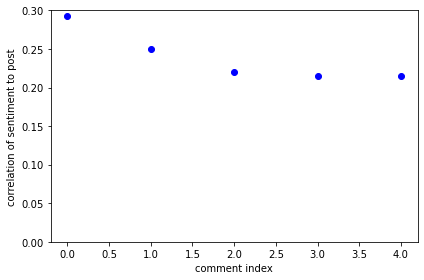

In [50]:
#plot it
for i in range(5):
    plt.scatter(x=int(i), y=op_corr_plots[i].loc["bert_compound_x", "bert_compound_y"], c="blue")
plt.xlabel("comment index")
plt.ylabel("correlation of sentiment to post")
plt.ylim((0,0.3))
#plt.show()
plt.tight_layout()
#plt.savefig("comment_chain_corr")


### Sentiment correlations between posts

In [51]:
#helper function to connect adjacent posts
def sentiment_transition(x, df, col="vader_score_compound"):
    #print(x)
    pid = x["post_id"]
    idx = x.name
    if idx+1 < len(df) and df.loc[idx, "user_id"] == df.loc[(idx+1, "user_id")]:
        return df.loc[(idx+1, col)]

In [52]:
#connect vader scores of adjacent posts
posts["vader_next"] = posts.apply(lambda x: sentiment_transition(x, posts, col="vader_score_compound"), axis=1)

In [53]:
#connect bert scores of adjacent posts
posts["bert_next"] = posts.apply(lambda x: sentiment_transition(x, posts, col="bert_compound"), axis=1)

In [54]:
#vader correlation
posts[["vader_score_compound", "vader_next"]].corr()

,vader_score_compound,vader_next
vader_score_compound,1.000000,0.049014
vader_next,0.049014,1.000000


In [55]:
#bert correlation
posts[["bert_compound", "bert_next"]].corr()

,bert_compound,bert_next
bert_compound,1.000000,0.103903
bert_next,0.103903,1.000000


### Emotion transitions of OP within comment chains

In [56]:
emotion_transition = pd.DataFrame(columns=merged.columns)
for pid in merged[merged["author"]==merged["user_id"]]["post_id"].unique():
    #filter for current user
    slice = merged[merged["author"]==merged["user_id"]]
    #sort by time
    slice = merged[merged["post_id"]==pid].sort_values("timestamp_y").reset_index(drop=True)
    for i in range(len(slice)):
        #first transition from post to comment
        if i==0:
            slice.loc[i, "emotion_from"] = slice.loc[i, "max_emotion_x"]
            slice.loc[i, "emotion_to"] = slice.loc[i, "max_emotion_y"]
        #transition between comments
        else:
            slice.loc[i, "emotion_from"] = slice.loc[i-1, "max_emotion_y"]
            slice.loc[i, "emotion_to"] = slice.loc[i, "max_emotion_y"]
    emotion_transition = pd.concat([emotion_transition, slice])

In [ ]:
#write to file
emotion_transition.to_csv("emotion_transition", index=False)

In [ ]:
#frequencies of transitions
et_matrix = emotion_transition[["emotion_to", "emotion_from"]].value_counts(normalize=True)

In [ ]:
#created shuffled reference 
emotion_transition_shuffled = emotion_transition.copy()
emotion_transition_shuffled["emotion_from"] = emotion_transition_shuffled["emotion_from"].sample(frac=1, ignore_index=True, random_state=0)
emotion_transition_shuffled["emotion_to"] = emotion_transition_shuffled["emotion_to"].sample(frac=1, ignore_index=True, random_state=1)
et_matrix_shuffled = emotion_transition_shuffled[["emotion_to", "emotion_from"]].value_counts(normalize=True)

In [ ]:
#raw frequencies in original
sns.heatmap(et_matrix.reset_index().pivot(columns="emotion_to", index="emotion_from", values=0), annot=True, fmt=".4f")

In [ ]:
#raw frequencies in shuffled
sns.heatmap(et_matrix_shuffled.reset_index().pivot(columns="emotion_to", index="emotion_from", values=0), annot=True, fmt=".4f")

In [ ]:
#normalized transition frequencies
sns.heatmap(et_matrix.reset_index().pivot(columns="emotion_to", index="emotion_from", values=0)/et_matrix_shuffled.reset_index().pivot(columns="emotion_to", index="emotion_from", values=0), annot=True, fmt=".3f")
plt.title("Normalized transition frequencies within comment chains")
plt.tight_layout()
plt.savefig("emotion_transition")

### Emotion transitions between posts

In [ ]:
#helper function to link adjacent posts
def emotion_post_transition(row, df):
    pid = row["post_id"]
    idx = row.name
    #make sure we don't go out of bounds and are not switching users
    if idx+1 < len(df) and df.loc[idx, "user_id"] == df.loc[(idx+1, "user_id")]:
        return df.loc[(idx+1, "max_emotion")]

In [ ]:
#make sure we have a time sequential order per user
posts = posts.sort_values(["user_id", "timestamp"])
#actual linking
posts["emotion_to"] = posts.apply(lambda x: emotion_post_transition(x, posts), axis=1)

In [ ]:
#create shuffled reference
post_emotion_transition_shuffled = posts.copy()
post_emotion_transition_shuffled["max_emotion"] = post_emotion_transition_shuffled["max_emotion"].sample(frac=1, ignore_index=True, random_state=0)
post_emotion_transition_shuffled["emotion_to"] = post_emotion_transition_shuffled["emotion_to"].sample(frac=1, ignore_index=True, random_state=1)

In [ ]:
#raw frequencies for original transitions
post_trans = posts[~posts["emotion_to"].isna()][["max_emotion", "emotion_to"]].value_counts(normalize=True)
sns.heatmap(post_trans.reset_index().pivot(columns="emotion_to", index="max_emotion", values=0), annot=True, fmt=".4f")

In [ ]:
#raw frequencies for shuffled transitions
post_emotion_transition_shuffled_mat = post_emotion_transition_shuffled[["max_emotion", "emotion_to"]].value_counts(normalize=True)
sns.heatmap(post_emotion_transition_shuffled_mat.reset_index().pivot(columns="emotion_to", index="max_emotion", values=0), annot=True, fmt=".4f")

In [ ]:
#normalized frequencies for post to post emotion transitions
sns.heatmap(post_trans.reset_index().pivot(columns="emotion_to", index="max_emotion", values=0)/post_emotion_transition_shuffled_mat.reset_index().pivot(columns="emotion_to", index="max_emotion", values=0), annot=True, fmt=".4f")
plt.ylabel("emotion_from")
plt.tight_layout()
#plt.savefig("post_emotion_transition")